In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('maladie_cardiaque.csv', usecols=lambda column: column != 'Unnamed: 0',index_col = 'id')

In [3]:
def resume_table(df):
    print("Format de la base : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"]).reset_index()
    summary["name"] = summary["index"]
    summary = summary[["name", "dtypes"]] # Correction : les colonnes doivent être spécifiées entre crochets
    summary["Missing"] = df.isnull().sum().values
    summary["Miss_percent"] = round((summary["Missing"] / len(df))*100, 2) # Correction : le calcul du pourcentage de valeurs manquantes doit être corrigé
    summary["Uniques"] = df.nunique().values
    summary["First Value"] = df.iloc[0].values
    summary["Second value"] = df.iloc[1].values
    summary["Third value"] = df.iloc[2].values
    return summary

In [4]:
resume_table(data)

Format de la base : (70000, 12)


,name,dtypes,Missing,Miss_percent,Uniques,First Value,Second value,Third value
0,age,int64,0,0.0,8076,18393,20228,18857
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,int64,0,0.0,109,168,156,165
3,Poids,float64,0,0.0,287,62.0,85.0,64.0
4,pression_systo,int64,0,0.0,153,110,140,130
5,pression_diasto,int64,0,0.0,157,80,90,70
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [5]:
data["age_annee"] = round(data["age"]/365.25,2)

In [6]:
# Créer les intervalles pour les classes d'âge
bins = [0, 18, 30, 45, 60, 100]

# Créer les étiquettes pour les classes d'âge
labels = ['moins de 18 ans', '18-30 ans', '30-45 ans', '45-60 ans', 'plus de 60 ans']

# Créer une nouvelle colonne 'classe_age' en utilisant la méthode cut()
data['classe_age'] = pd.cut(data['age_annee'], bins=bins, labels=labels)

In [7]:
data['malade'] = data["malade"].map({'oui': 1, 'non': 0})
data['fumeur'] = data["fumeur"].map({'fumeur': 1, 'non fumeur': 0})
data['conso_alco'] = data["conso_alco"].map({'oui': 1, 'non': 0})

In [8]:
data.sample(10)

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,age_annee,classe_age
id,,,,,,,,,,,,,,
99031,23271,homme,163,70.0,120,80,normal,1,0,0,1,1,63.71,plus de 60 ans
84353,19592,femme,160,64.0,120,80,normal,1,0,0,1,1,53.64,45-60 ans
32964,18947,homme,174,83.0,140,87,normal,1,0,0,1,1,51.87,45-60 ans
28396,23392,homme,165,67.0,110,70,normal,1,0,0,0,1,64.04,plus de 60 ans
14878,16723,homme,172,79.0,120,80,normal,1,0,0,0,0,45.79,45-60 ans
57804,20437,femme,168,54.0,140,100,tres eleve,1,0,0,1,1,55.95,45-60 ans
6616,22047,femme,165,100.0,140,80,tres eleve,3,0,0,0,1,60.36,plus de 60 ans
39624,15365,homme,160,60.0,120,80,normal,1,0,0,1,0,42.07,30-45 ans
42406,14634,femme,162,53.0,100,50,normal,1,0,0,1,0,40.07,30-45 ans


In [9]:
def imc_category(row):
    taille_m = row['taille'] / 100  # Convertir la taille en mètres
    imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
    if imc < 18.5:
        return 'Maigre'
    elif imc < 25:
        return 'Normal'
    elif imc < 30:
        return 'Surpoids'
    else:
        return 'Obèse'
data['IMC'] = data.apply(lambda row: row['Poids'] / ((row['taille'] / 100) ** 2), axis=1)
data['IMC_Category'] = data.apply(imc_category, axis=1)

In [10]:
data

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,age_annee,classe_age,IMC,IMC_Category
id,,,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,0,0,1,0,50.36,45-60 ans,21.967120,Normal
1,20228,femme,156,85.0,140,90,tres eleve,1,0,0,1,1,55.38,45-60 ans,34.927679,Obèse
2,18857,femme,165,64.0,130,70,tres eleve,1,0,0,0,1,51.63,45-60 ans,23.507805,Normal
3,17623,homme,169,82.0,150,100,normal,1,0,0,1,1,48.25,45-60 ans,28.710479,Surpoids
4,17474,femme,156,56.0,100,60,normal,1,0,0,0,0,47.84,45-60 ans,23.011177,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,homme,168,76.0,120,80,normal,1,1,0,1,0,52.68,45-60 ans,26.927438,Surpoids
99995,22601,femme,158,126.0,140,90,eleve,2,0,0,1,1,61.88,plus de 60 ans,50.472681,Obèse
99996,19066,homme,183,105.0,180,90,tres eleve,1,0,1,0,1,52.20,45-60 ans,31.353579,Obèse


In [11]:
cat_cols = data.select_dtypes(exclude=['int64', 'float64']).columns

# Appliquer get_dummies sur les colonnes catégorielles
df_onehot = pd.get_dummies(data, columns=cat_cols)


In [12]:
df_onehot

,age,taille,Poids,pression_systo,pression_diasto,glycemie,fumeur,conso_alco,activite_physique,malade,...,cholesterol_tres eleve,classe_age_moins de 18 ans,classe_age_18-30 ans,classe_age_30-45 ans,classe_age_45-60 ans,classe_age_plus de 60 ans,IMC_Category_Maigre,IMC_Category_Normal,IMC_Category_Obèse,IMC_Category_Surpoids
id,,,,,,,,,,,,,,,,,,,,,
0,18393,168,62.0,110,80,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,20228,156,85.0,140,90,1,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
2,18857,165,64.0,130,70,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
3,17623,169,82.0,150,100,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
4,17474,156,56.0,100,60,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,168,76.0,120,80,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
99995,22601,158,126.0,140,90,2,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
99996,19066,183,105.0,180,90,1,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0


In [13]:
df_onehot = df_onehot.drop(['classe_age_moins de 18 ans','genre_homme', 'age_annee', 'age', 'Poids', 'taille','IMC'], axis=1)

In [14]:
from scipy.stats import pearsonr
for colonne in df_onehot.columns:
# Calculer le coefficient de corrélation de Pearson entre la variable explicative X et la cible y
    print(colonne)
    corr, _ = pearsonr(df_onehot[colonne], df_onehot.malade)

    # Afficher le coefficient de corrélation
    print('Coefficient de corrélation de Pearson : {:.2f}'.format(corr))


pression_systo
Coefficient de corrélation de Pearson : 0.05
pression_diasto
Coefficient de corrélation de Pearson : 0.07
glycemie
Coefficient de corrélation de Pearson : 0.09
fumeur
Coefficient de corrélation de Pearson : -0.02
conso_alco
Coefficient de corrélation de Pearson : -0.01
activite_physique
Coefficient de corrélation de Pearson : -0.04
malade
Coefficient de corrélation de Pearson : 1.00
genre_femme
Coefficient de corrélation de Pearson : -0.01
cholesterol_eleve
Coefficient de corrélation de Pearson : 0.08
cholesterol_normal
Coefficient de corrélation de Pearson : -0.21
cholesterol_tres eleve
Coefficient de corrélation de Pearson : 0.19
classe_age_18-30 ans
Coefficient de corrélation de Pearson : -0.01
classe_age_30-45 ans
Coefficient de corrélation de Pearson : -0.17
classe_age_45-60 ans
Coefficient de corrélation de Pearson : -0.01
classe_age_plus de 60 ans
Coefficient de corrélation de Pearson : 0.16
IMC_Category_Maigre
Coefficient de corrélation de Pearson : -0.04
IMC_Cat

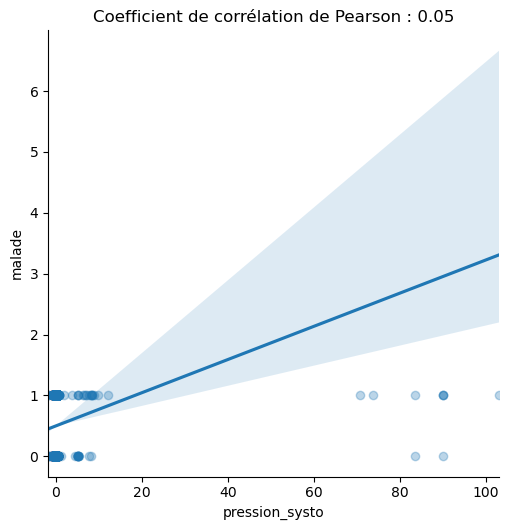

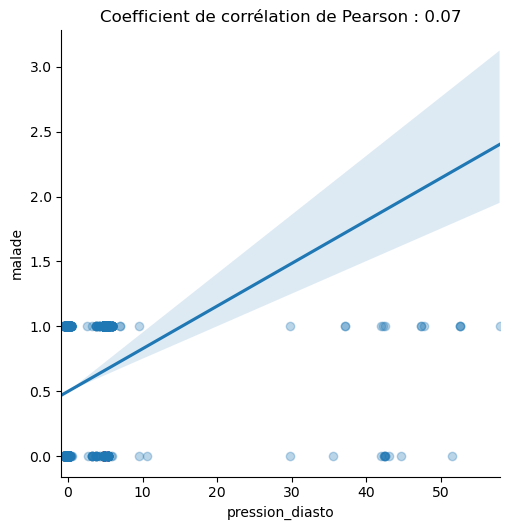

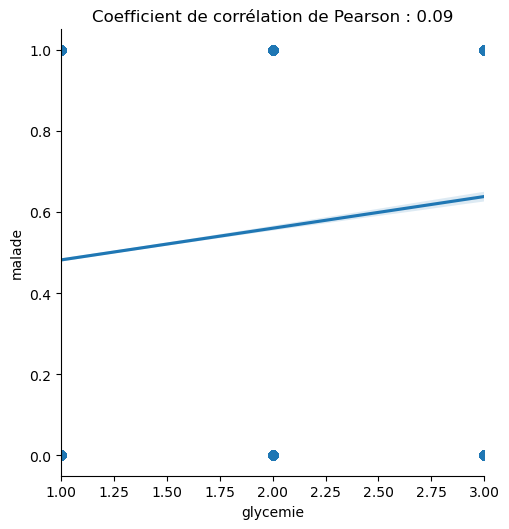

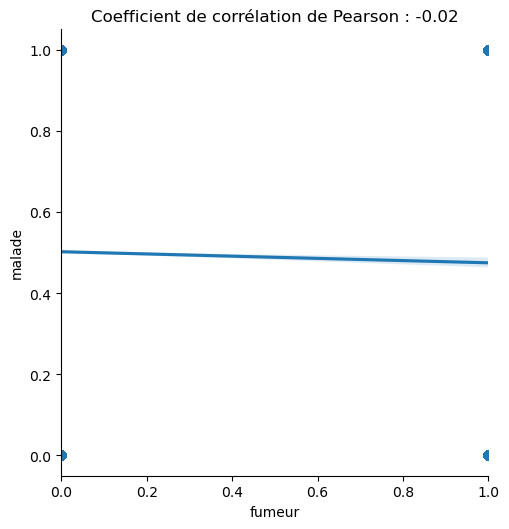

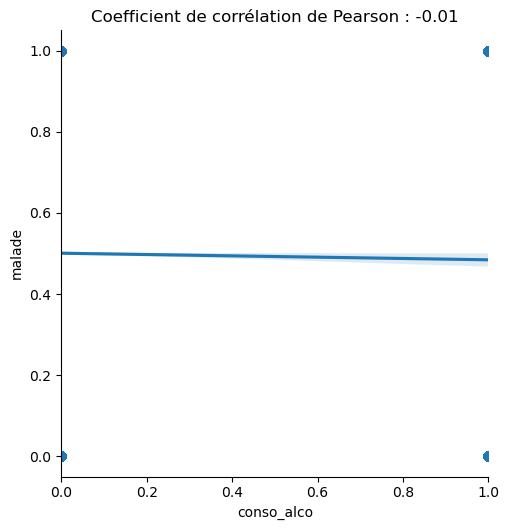

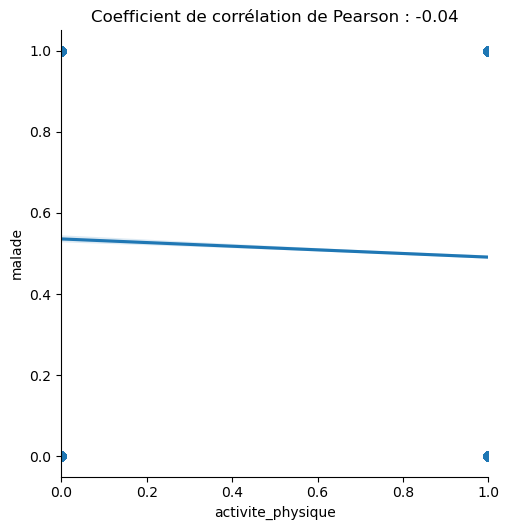

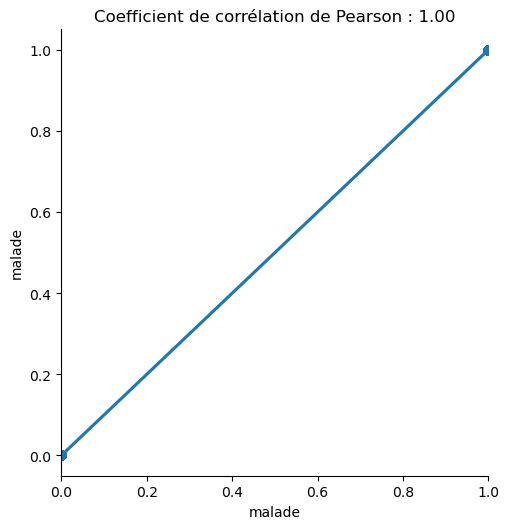

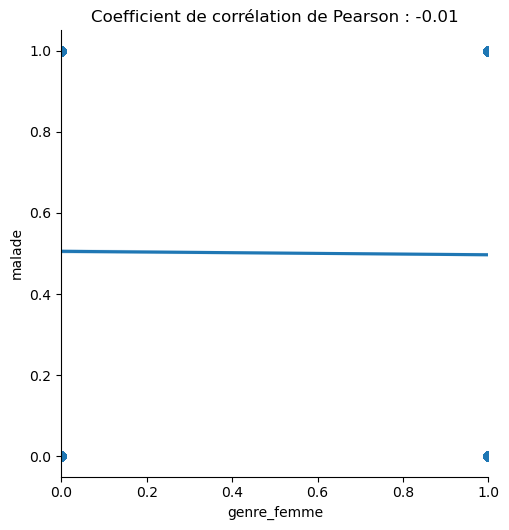

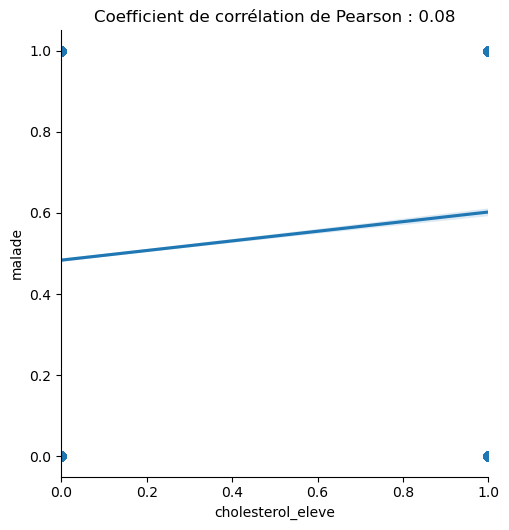

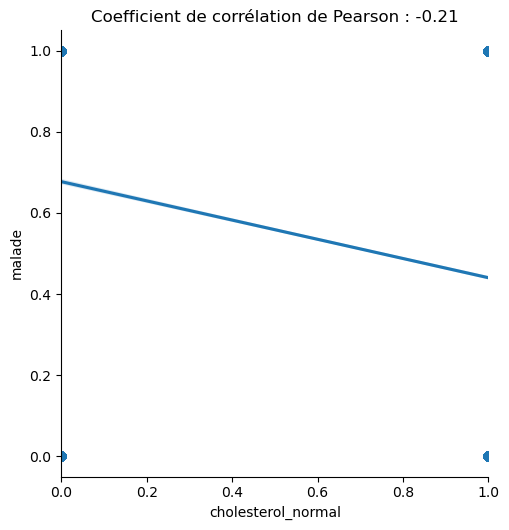

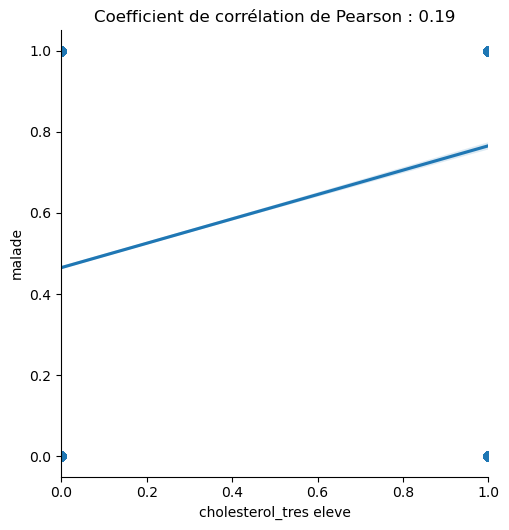

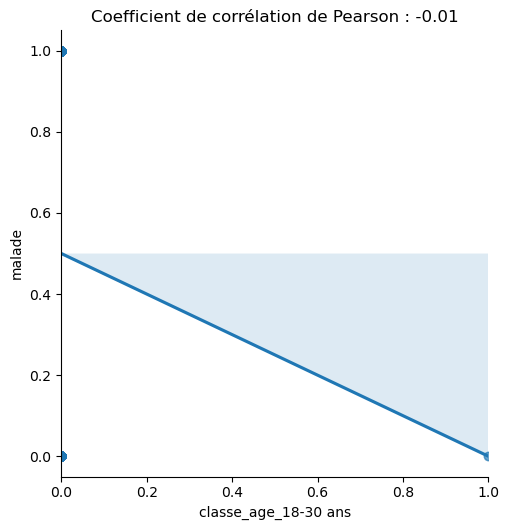

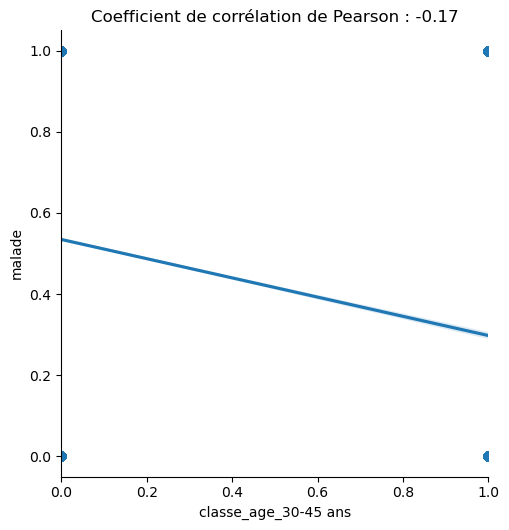

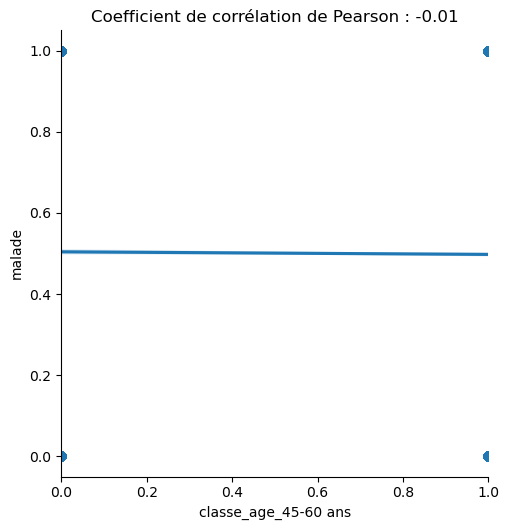

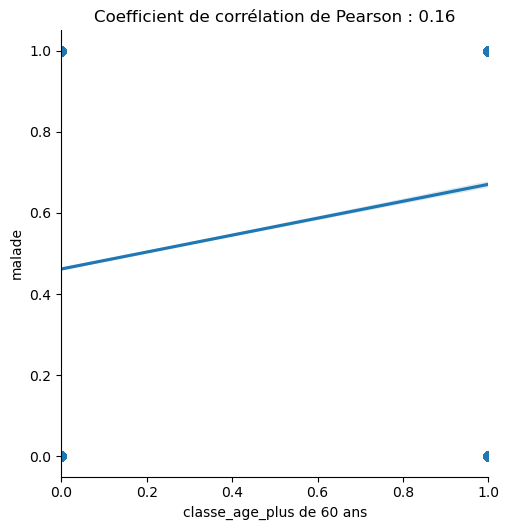

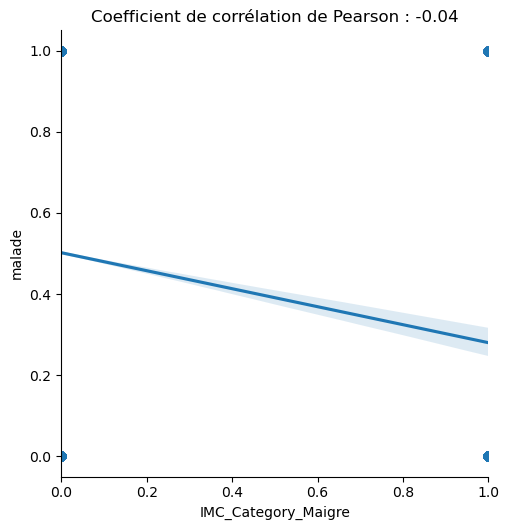

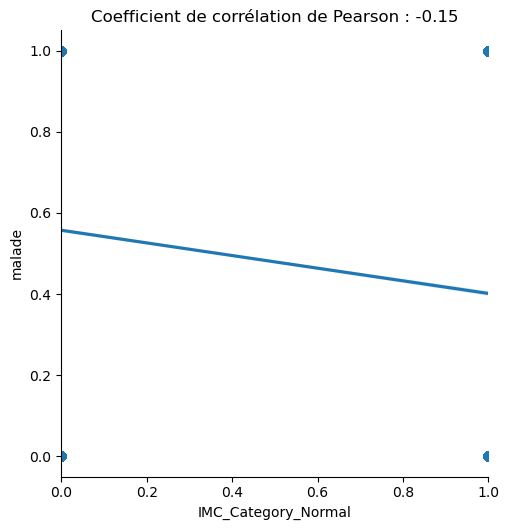

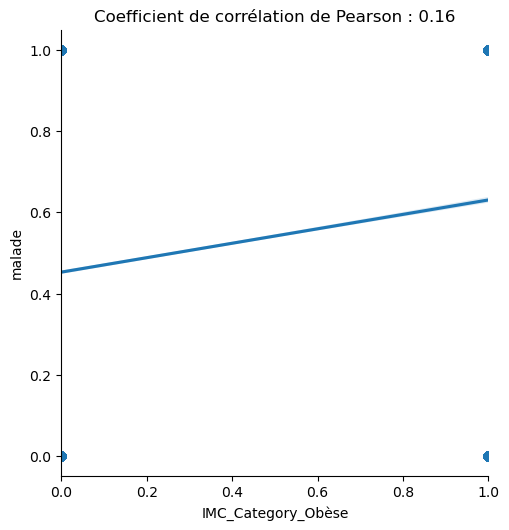

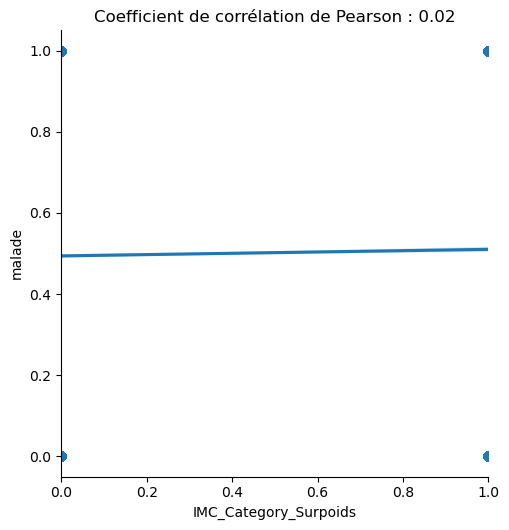

In [18]:
import matplotlib.pyplot as plt

for colonne in df_onehot.columns:
    # Calculer le coefficient de corrélation de Pearson entre la variable explicative X et la cible y
    corr, _ = pearsonr(df_onehot[colonne], df_onehot.malade)

    # Créer un scatter plot avec une ligne de régression linéaire
    sns.lmplot(x=colonne, y='malade', data=df_onehot, scatter_kws={'alpha':0.3})

    # Ajouter le coefficient de corrélation dans le titre
    plt.title('Coefficient de corrélation de Pearson : {:.2f}'.format(corr))

    # Afficher la figure
    plt.show()


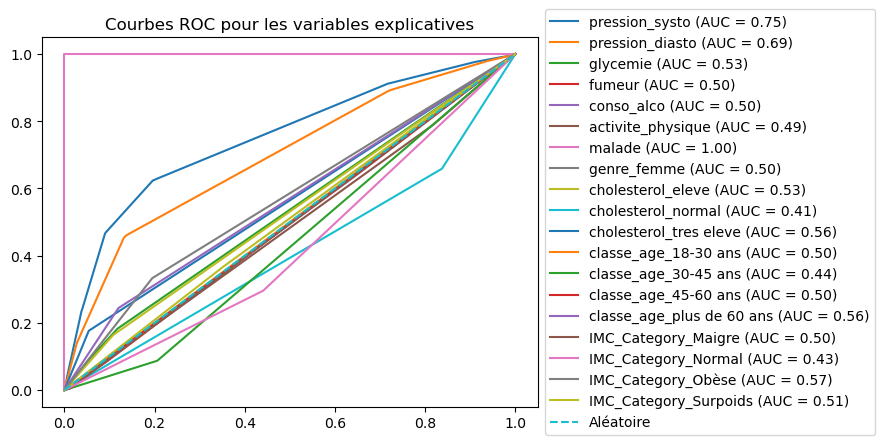

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for colonne in df_onehot.columns:
    # Calculer la courbe ROC et l'AUC pour la variable explicative X et la cible y
    fpr, tpr, thresholds = roc_curve(df_onehot.malade, df_onehot[colonne])
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(colonne, roc_auc))

# Afficher la courbe de référence (aléatoire)
plt.plot([0, 1], [0, 1], '--', label='Aléatoire')

# Ajouter une légende et un titre
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Courbes ROC pour les variables explicatives')

# Afficher la figure
plt.show()


In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score
from itertools import combinations
from sklearn.feature_selection import f_classif
from itertools import combinations


# Définir les colonnes d'entrée et de sortie
X = df_onehot.drop('malade', axis=1)
y = df_onehot['malade']

# Définir le nombre de colonnes à sélectionner
k = 5

# Créer une liste de toutes les combinaisons possibles de k colonnes
combinaisons = combinations(X.columns, k)

# Initialiser les variables pour stocker la meilleure combinaison et son score F ANOVA
meilleure_combinaison = None
meilleur_score = 0

# Boucle à travers toutes les combinaisons et trouver celle avec le meilleur score F ANOVA
for combinaison in combinaisons:
    # Sélectionner les colonnes de la combinaison actuelle
    X_combinaison = X[list(combinaison)]
    
    # Sélectionner les k meilleures colonnes en utilisant le score F ANOVA comme mesure de qualité
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_combinaison, y)
    
    # Calculer le score F ANOVA pour les colonnes sélectionnées
    score = sum(selector.scores_)
    
    # Mettre à jour les variables pour stocker la meilleure combinaison et son score F ANOVA
    if score > meilleur_score:
        meilleure_combinaison = combinaison
        meilleur_score = score
        
# Afficher la meilleure combinaison et son score F ANOVA correspondant
print("Meilleure combinaison de colonnes:", meilleure_combinaison)
print("Score F ANOVA pour la meilleure combinaison:", meilleur_score)

Meilleure combinaison de colonnes: ('cholesterol_normal', 'cholesterol_tres eleve', 'classe_age_30-45 ans', 'classe_age_plus de 60 ans', 'IMC_Category_Obèse')
Score F ANOVA pour la meilleure combinaison: 11414.066040039062


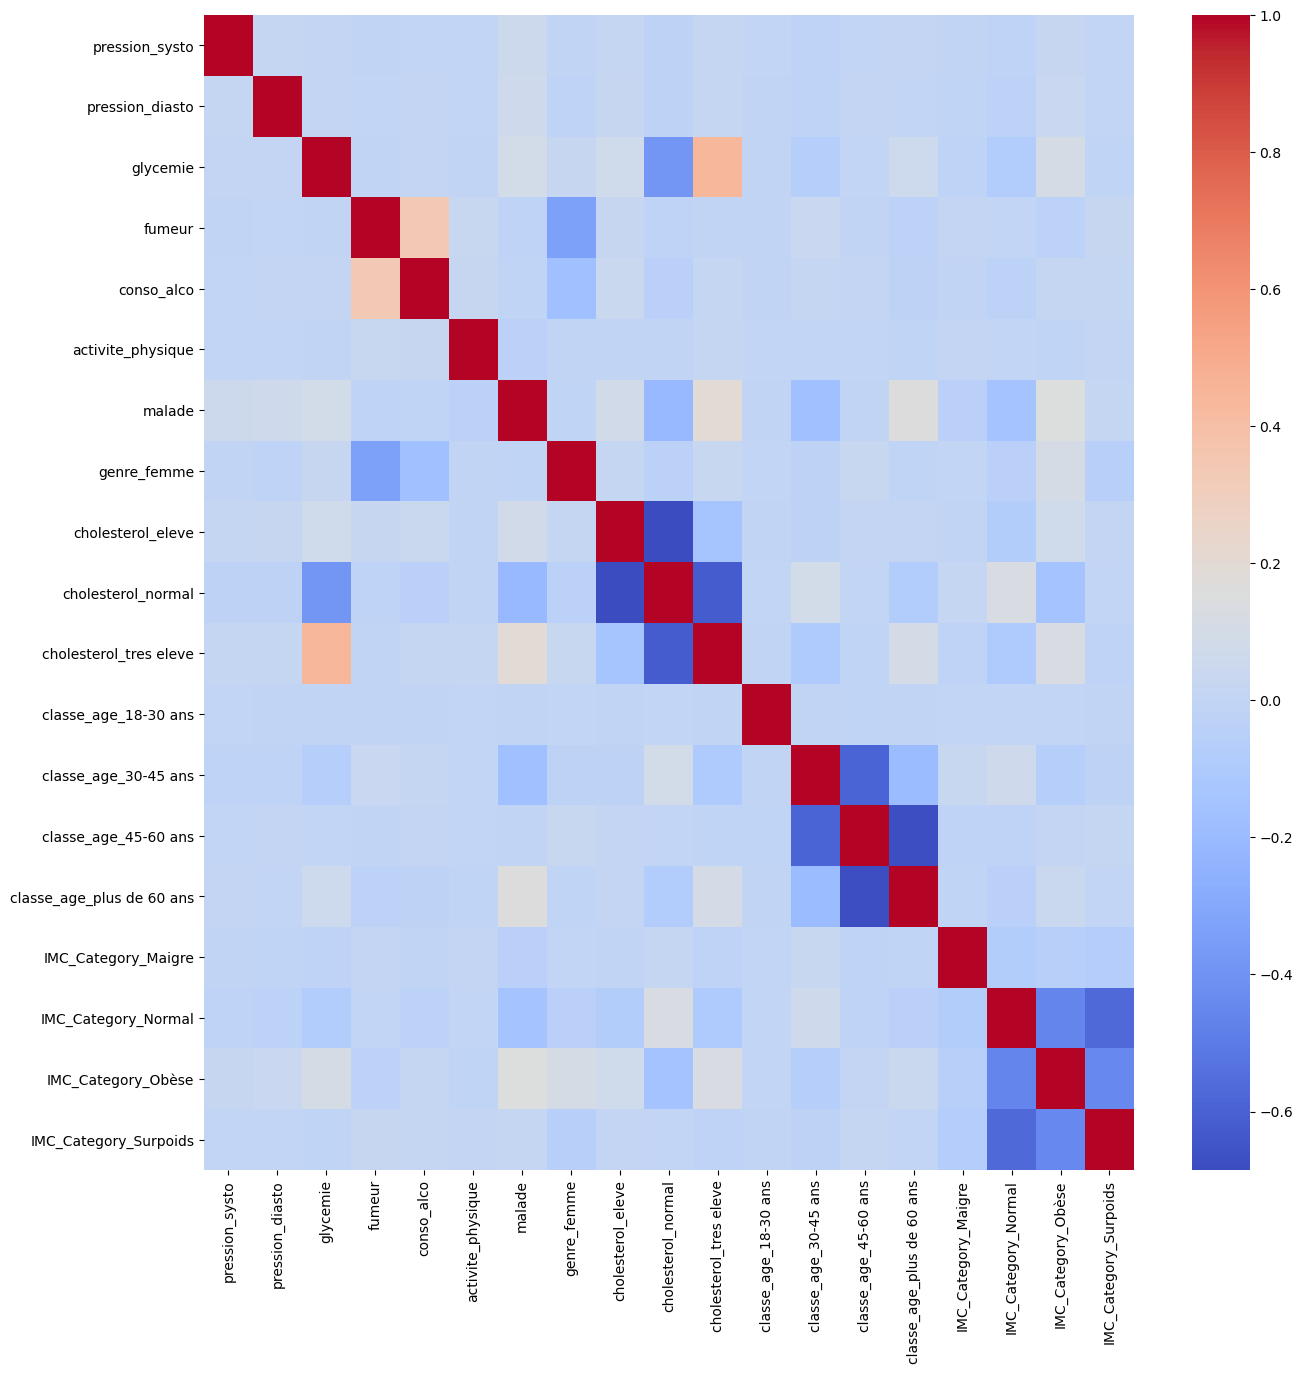

In [15]:
corr_matrix = df_onehot.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm')

# Afficher le graphique
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_onehot[['pression_systo', 'pression_diasto']] = scale.fit_transform(df_onehot[['pression_systo', 'pression_diasto']])
selector = VarianceThreshold(threshold = 0.0001)
#df_onehot = selector.fit_transform(df_onehot)

In [17]:
# Séparer les variables cibles et les variables prédictives
X = df_onehot.drop('malade', axis=1)
y = df_onehot['malade']
#X = selector.fit_transform(X)
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Créer un objet RandomForestClassifier avec des paramètres par défaut
rfc = RandomForestClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
rfc.fit(X_train, y_train)

# Évaluer les performances du modèle sur l'ensemble de test
score = rfc.score(X_test, y_test)

# Afficher le score
print('Score : {:.2f}'.format(score))

Score : 0.72


In [43]:
X.shape

(70000, 18)

In [54]:
rfc = RandomForestClassifier()
#from sklearn.linear_model import LogisticRegression
#rfc = LogisticRegression()
rfecv = RFECV(estimator=rfc, cv=5)
# Appliquer RFECV sur les données d'entraînement
rfecv.fit(X_train, y_train)

# Afficher le nombre de variables sélectionnées
print('Nombre de variables sélectionnées : {}'.format(rfecv.n_features_))

# Afficher les noms de colonnes des variables sélectionnées
print('Variables sélectionnées :')
for col in X.columns[rfecv.support_]:
    print(col)

KeyboardInterrupt: 

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


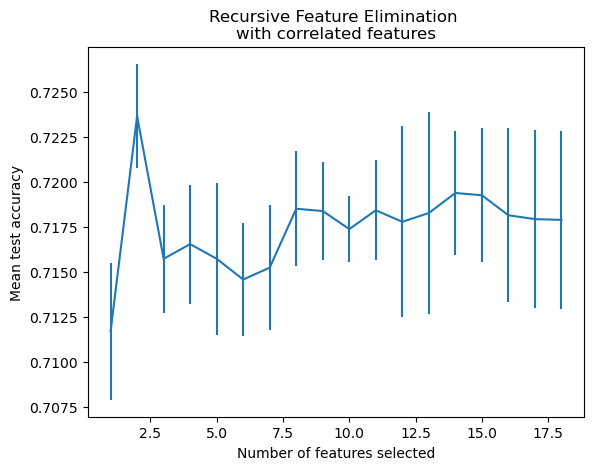

In [45]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, len(rfecv.grid_scores_) + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [52]:
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but RFECV is expecting 18 features as input.

In [53]:
rfc = RandomForestClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
rfc.fit(X_train, y_train)

# Évaluer les performances du modèle sur l'ensemble de test
score = rfc.score(X_test, y_test)

In [48]:
print(score)

0.7296969696969697


In [49]:
import itertools

def print_nice_conf_matrix(y, cnf_matrix):
    '''
    Fonction dediee a rendre une jolie matrice de confusion a partir de :
        - y : un array contenant les classes pour la classification. 
               Sert uniquement a compter le nombre de classes.
        - cnf_matrix : la matrice de confusion qui nous interesse.
    '''
    classes = range(0,(len(np.unique(y))))

    plt.figure()

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

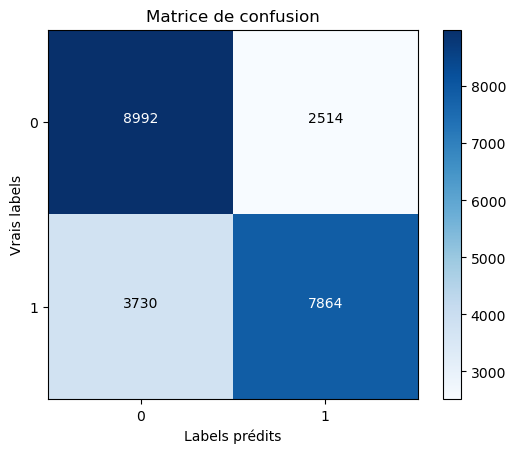

Confusion Matrix:
 None
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74     11506
           1       0.76      0.68      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



In [50]:
from sklearn.metrics import confusion_matrix, classification_report

# obtenir les prédictions pour chaque classe
pred = rfc.predict(X_test)

# créer la matrice de confusion
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", print_nice_conf_matrix(y_test, cm))

# créer le rapport de classification
report = classification_report(y_test, pred)
print("Classification Report:\n", report)





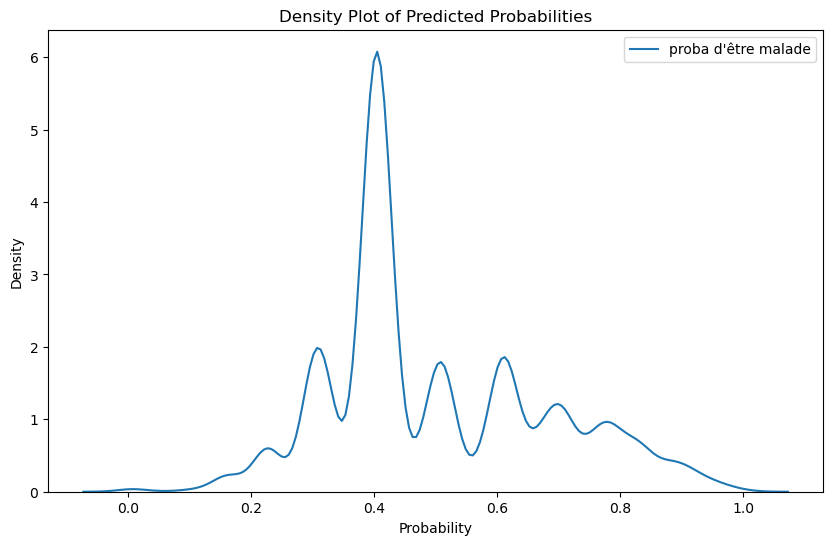

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
proba_pred  = rfc.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()


In [26]:
# Créer un objet RandomForestClassifier
rfc = RandomForestClassifier()

# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [50, 100,150],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

# Créer un objet GridSearchCV avec le modèle de classification et la grille de paramètres à optimiser
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Appliquer GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score de validation croisée correspondant
print('Meilleurs hyperparamètres : {}'.format(grid_search.best_params_))
print('Score de validation croisée correspondant : {:.2f}'.format(grid_search.best_score_))

# Évaluer les performances du modèle sur l'ensemble de test avec les meilleurs hyperparamètres
score = grid_search.score(X_test, y_test)

# Afficher le score
print('Score sur ensemble de test : {:.2f}'.format(score))

Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Score de validation croisée correspondant : 0.73
Score sur ensemble de test : 0.73


In [151]:
test = []
for prob in proba_pred:
    if prob[1] <0.45:
        test.append(0)
    else:
        test.append(1)
        

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     11506
           1       0.73      0.73      0.73     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



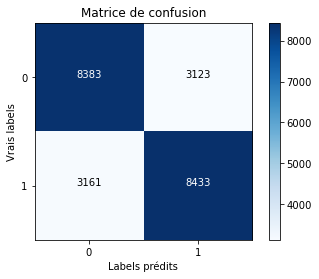

In [152]:
print(classification_report(y_test, test))
cm = confusion_matrix(y_test, test)
print_nice_conf_matrix(y_test, cm)

In [160]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Appliquer la PCA sur les données X
pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)



In [161]:
# Afficher les valeurs propres de chaque composante principale
print("Eigenvalues:\n", pca.explained_variance_)

# Afficher le pourcentage de variance expliqué par chaque composante principale
print("Explained variance ratio:\n", pca.explained_variance_ratio_)

# Afficher les composantes principales
print("Principal components:\n", pca.components_)


Eigenvalues:
 [1.14149487 1.09291437 0.24826359 0.15874459]
Explained variance ratio:
 [0.40796189 0.39059957 0.08872758 0.05673415]
Principal components:
 [[ 3.64191237e-01  9.31075674e-01 -1.80635231e-02  8.07280350e-03
  -7.27942854e-03  4.28733819e-03]
 [ 9.31186252e-01 -3.64430174e-01 -5.53388734e-03  4.23651463e-03
  -4.19752329e-03  4.07689663e-03]
 [ 1.53892853e-02  1.65850301e-02  8.15169915e-01 -5.06810285e-01
   1.80880805e-01 -2.13099944e-01]
 [ 3.92937905e-03  2.66482184e-04 -2.53891083e-01  1.15891475e-01
   5.10018214e-01 -8.13618089e-01]]


In [162]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print("Variance explained by each component:", var_exp)
print("Cumulative variance explained by each component:", cum_var_exp)

Variance explained by each component: [0.40796189 0.39059957 0.08872758 0.05673415]
Cumulative variance explained by each component: [0.40796189 0.79856146 0.88728905 0.9440232 ]


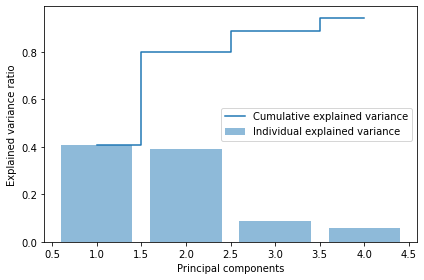

In [163]:
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [164]:
X_test_pca = pca.fit_transform(X_test)

In [165]:
rfc = RandomForestClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
rfc.fit(X_train_pca, y_train)

# Évaluer les performances du modèle sur l'ensemble de test
score = rfc.score(X_test_pca, y_test)

In [166]:
score

0.7170562770562771